In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [22]:
file_path = '波士顿房价.csv'
df = pd.read_csv(file_path, header=0)
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [51]:
# 随机选取一个特征用于画图与训练模型
label = list(df.columns)
label = [i for i in label if i != 'MEDV' ]
select_label = random.sample(label,1)
select_label.append('MEDV')
data = df[select_label]
data

,NOX,MEDV
0,0.538,24.0
1,0.469,21.6
2,0.469,34.7
3,0.458,33.4
4,0.458,36.2
...,...,...
501,0.573,22.4
502,0.573,20.6
503,0.573,23.9
504,0.573,22.0


<Axes: xlabel='NOX', ylabel='MEDV'>

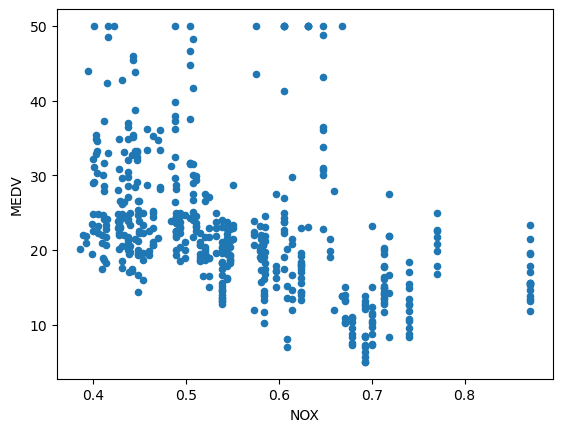

In [52]:
data.plot(kind='scatter',x=select_label[0],y='MEDV')

In [53]:
x_data = data.drop(columns='MEDV')
y_data = data['MEDV']

In [54]:
# 将DataFrame转换为PyTorch张量
X = torch.tensor(x_data.values, dtype=torch.float32)
y = torch.tensor(y_data.values, dtype=torch.float32).reshape(-1, 1)

In [57]:
# 数据加载器
def data_iter(batch_size, data, labels):
    num_examples = len(data)
    indices = list(range(num_examples))
    # 随机读取样本
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield data[batch_indices], labels[batch_indices]

In [58]:
# 定义线性回归模型
def linear(X, a, b):
    return torch.matmul(X, a) + b
# 定义损失函数
def loss(y,y_hat):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2
# 梯度下降
def sgd(params,lr,batch_size):
    """
    params:模型参数
    lr:学习率
    batch_size:每次读取的数据量的数量
    """
    with torch.no_grad():   # 不对梯度进行追踪，保证后续参数的更新不被影响
        for param in params:
            param -= lr*param.grad / batch_size
            param.grad.zero_()   # 清空梯度
def backwards(X,y,y_hat,a,b):
    """
    X:输入的数据
    y:真实值
    y_hat:预测值
    a:模型参数
    b:偏置值
    """
    y_hat_grad = y_hat-y
    a_grad = torch.matmul(X.T,y_hat_grad)
    b_grad = y_hat_grad.sum(dim=0)
    a.grad = a_grad
    b.grad = b_grad

In [59]:
model = linear  # 模型
lr = 0.03   # 学习率
num_epochs = 500    # 训练次数
batch_size = 10 # 一次读取的数据量

In [60]:
# 初始化模型参数
# 模型为 y = ax + b
a = torch.normal(0, 0.01, size=(len(select_label)-1,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [62]:
for epoch in range(num_epochs): #训练模型
    for X_train,y_train in data_iter(batch_size,X,y):
        y_hat = model(X_train,a,b)
        train_loss = loss(y_hat,y_train)
        backwards(X_train,y_train,y_hat,a,b)
        #backward(X,y,y_hat,a,b)
        sgd([a,b],lr,batch_size)
    with torch.no_grad():   # 模型评估
        train_l = loss(model(X,a,b), y)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 51.595737
epoch 2, loss 46.572895
epoch 3, loss 46.061150
epoch 4, loss 45.772415
epoch 5, loss 45.371628
epoch 6, loss 45.041618
epoch 7, loss 44.694214
epoch 8, loss 44.388058
epoch 9, loss 44.091347
epoch 10, loss 43.846420
epoch 11, loss 43.503551
epoch 12, loss 43.256580
epoch 13, loss 42.969662
epoch 14, loss 42.705551
epoch 15, loss 42.452007
epoch 16, loss 42.213535
epoch 17, loss 41.974945
epoch 18, loss 41.749390
epoch 19, loss 41.540043
epoch 20, loss 41.316391
epoch 21, loss 41.100056
epoch 22, loss 40.951496
epoch 23, loss 40.705547
epoch 24, loss 40.519794
epoch 25, loss 40.351158
epoch 26, loss 40.158756
epoch 27, loss 39.977421
epoch 28, loss 39.822666
epoch 29, loss 39.662193
epoch 30, loss 39.511520
epoch 31, loss 39.336670
epoch 32, loss 39.193253
epoch 33, loss 39.070732
epoch 34, loss 38.917419
epoch 35, loss 38.771690
epoch 36, loss 38.649063
epoch 37, loss 38.569118
epoch 38, loss 38.412128
epoch 39, loss 38.273705
epoch 40, loss 38.189037
epoch 41,

In [64]:
# 最后一次训练得出的模型效果
for i in range(len(X)):
    y_hat = model(X[i],a,b)
    print(f'{y[i]}-{y_hat}')
print('test_loss:',loss(y,model(X,a,b)).mean())

tensor([24.])-tensor([23.2515], grad_fn=<AddBackward0>)
tensor([21.6000])-tensor([25.5859], grad_fn=<AddBackward0>)
tensor([34.7000])-tensor([25.5859], grad_fn=<AddBackward0>)
tensor([33.4000])-tensor([25.9581], grad_fn=<AddBackward0>)
tensor([36.2000])-tensor([25.9581], grad_fn=<AddBackward0>)
tensor([28.7000])-tensor([25.9581], grad_fn=<AddBackward0>)
tensor([22.9000])-tensor([23.7251], grad_fn=<AddBackward0>)
tensor([27.1000])-tensor([23.7251], grad_fn=<AddBackward0>)
tensor([16.5000])-tensor([23.7251], grad_fn=<AddBackward0>)
tensor([18.9000])-tensor([23.7251], grad_fn=<AddBackward0>)
tensor([15.])-tensor([23.7251], grad_fn=<AddBackward0>)
tensor([18.9000])-tensor([23.7251], grad_fn=<AddBackward0>)
tensor([21.7000])-tensor([23.7251], grad_fn=<AddBackward0>)
tensor([20.4000])-tensor([23.2515], grad_fn=<AddBackward0>)
tensor([18.2000])-tensor([23.2515], grad_fn=<AddBackward0>)
tensor([19.9000])-tensor([23.2515], grad_fn=<AddBackward0>)
tensor([23.1000])-tensor([23.2515], grad_fn=<Add

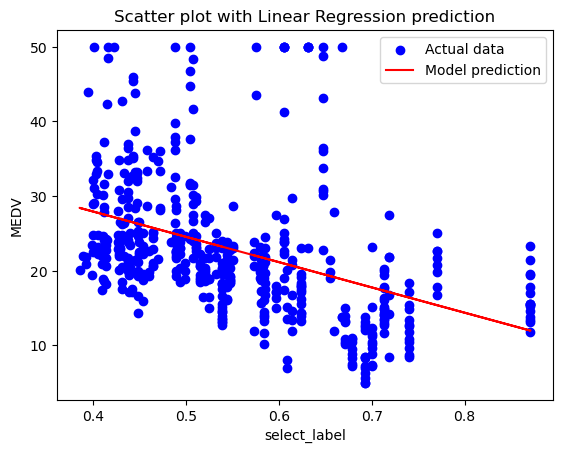

In [65]:
y_pred = model(X,a,b).detach().numpy()
# 绘制散点图
plt.scatter(data[select_label[0]], data['MEDV'], color='blue', label='Actual data')
# 绘制模型的预测线
plt.plot(X, y_pred, color='red', label='Model prediction')
# 添加标题和图例
plt.title('Scatter plot with Linear Regression prediction')
plt.xlabel('select_label')
plt.ylabel('MEDV')
plt.legend()
# 显示图表
plt.show()

In [82]:
print(a)
print(b)

tensor([[-33.8329]], requires_grad=True)
tensor([41.4535], requires_grad=True)
